In [38]:
# Carga y preprocesamiento de datos

import pandas as pd
import re
from Bio import SeqIO
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Rutas a archivos
path_genoma      = 'C:/Users/judit/OneDrive/Escritorio/MÁSTER/TFM/data/BVBRC_genome_amr.xlsx'
path_genes       = 'C:/Users/judit/OneDrive/Escritorio/MÁSTER/TFM/data/BVBRC_sp_gene.xlsx'
path_genes_fasta = 'C:/Users/judit/OneDrive/Escritorio/MÁSTER/TFM/data/BVBRC_genome_feature.fasta'

# 1. Leer datos fenotipos y SP-Genes
df_genoma = pd.read_excel(path_genoma, dtype=str)
df_genes  = pd.read_excel(path_genes, dtype=str)
if 'BRC ID' not in df_genes.columns:
    raise ValueError("Falta la columna 'BRC ID' en df_genes.")

# 2. Procesar FASTA para extraer fasta_entries
fasta_entries = []
for record in SeqIO.parse(path_genes_fasta, "fasta"):
    parts = record.id.split('|')
    if len(parts) >= 2 and parts[0] == 'fig':
        brc_id = f"{parts[0]}|{parts[1]}"
        m = re.match(r'(\d+\.\d+)', parts[1])
        genome_id = m.group(1) if m else None
        if genome_id:
            fasta_entries.append({
                'BRC_ID_completo': brc_id,
                'Genome_ID': genome_id
            })

# 3. Crear df_fasta y gene_presence
df_fasta = pd.DataFrame(fasta_entries)
df_fasta['presence'] = 1
df_fasta['Genome ID'] = df_fasta['Genome_ID'].str.strip().str.lower()

gene_presence = df_fasta.pivot_table(
    index='Genome ID',
    columns='BRC_ID_completo',
    values='presence',
    aggfunc='max',
    fill_value=0
)
gene_presence.index = gene_presence.index.str.strip().str.lower()

# 4. Preparar df_genoma: quedarnos solo con “Genome ID” y binarizar “Resistance”
df_genoma['Genome ID'] = df_genoma['Genome ID'].astype(str).str.strip().str.lower()
df_genoma['Resistance'] = df_genoma['Resistant Phenotype'].map({'Resistant': 1, 'Susceptible': 0})
df_genoma = df_genoma[['Genome ID', 'Resistance']]

# 5. Merge “fenotipo + presencia de genes” (solo genomas comunes)
df_full = df_genoma.merge(
    gene_presence,
    left_on='Genome ID',
    right_index=True,
    how='inner'
).fillna(0)

# 6. Separar X_all e y_all
y_all = df_full['Resistance']
X_all = df_full.drop(columns=['Resistance', 'Genome ID'])

# 7. División estratificada en entrenamiento y prueba (70/30)
X_train_all, X_test_all, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.30,
    stratify=y_all,
    random_state=42
)

print("Tamaño X_train_all:", X_train_all.shape[0])
print("Tamaño X_test_all: ", X_test_all.shape[0])   

# 8. Selección de top 100 genes SOLO sobre X_train_all
gene_counts_train = X_train_all.sum(axis=0)
selected_genes = gene_counts_train.sort_values(ascending=False).head(100).index.tolist()
print("Cantidad de genomas en entrenamiento:", X_train_all.shape[0])
print("Genes seleccionados (top 100 sobre train):", len(selected_genes))

# 9. Filtrar X_train_all y X_test_all a esas columnas seleccionadas
X_train = X_train_all[selected_genes].copy()
X_test  = X_test_all[selected_genes].copy()

# 10. Escalar con MinMaxScaler (RF + ADASYN) y StandardScaler (SVM/XGB)
scaler_mm  = MinMaxScaler()
scaler_std = StandardScaler()

X_train_scaled_mm = scaler_mm.fit_transform(X_train)
X_test_scaled_mm  = scaler_mm.transform(X_test)

X_train_scaled_std = scaler_std.fit_transform(X_train)
X_test_scaled_std  = scaler_std.transform(X_test)

Tamaño X_train_all: 10473
Tamaño X_test_all:  4489
Cantidad de genomas en entrenamiento: 10473
Genes seleccionados (top 100 sobre train): 100


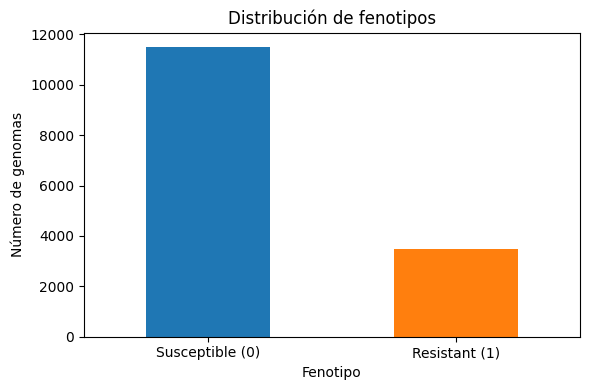

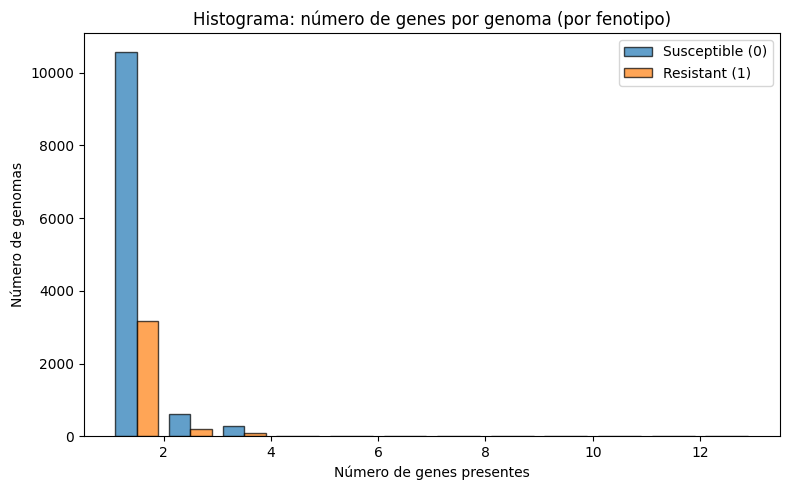

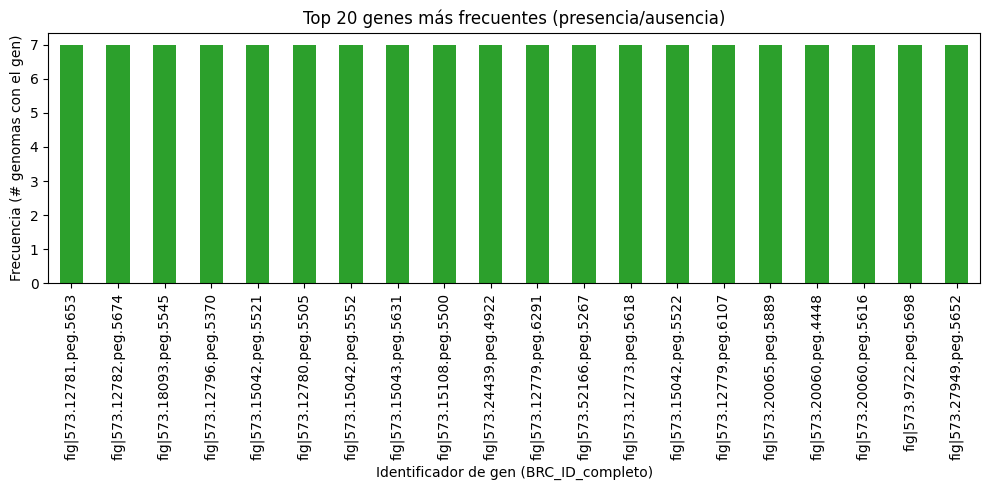

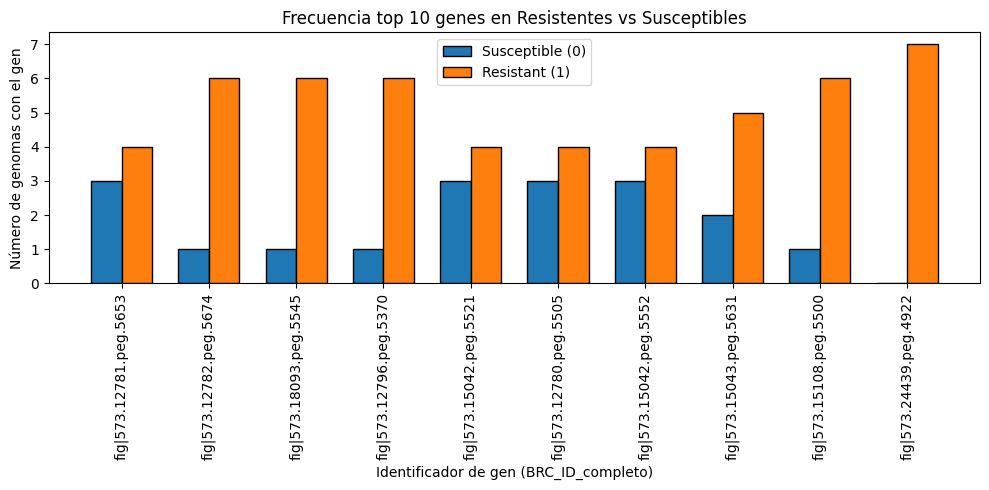

Estadísticas de número de genes por genoma (por fenotipo):

               count      mean       std  min  25%  50%  75%   max
Resistance                                                        
Susceptible  11490.0  1.114012  0.456350  1.0  1.0  1.0  1.0  12.0
Resistant     3472.0  1.130472  0.475834  1.0  1.0  1.0  1.0   6.0


In [39]:
import matplotlib.pyplot as plt

# Para no modificar df_full original, trabajamos con una copia
df_desc = df_full.copy()

# 2.1 Distribución global de fenotipos
phenotype_counts = df_desc['Resistance'].value_counts().sort_index()
phenotype_counts.index = ['Susceptible (0)', 'Resistant (1)']

plt.figure(figsize=(6, 4))
phenotype_counts.plot(kind='bar', color=['tab:blue', 'tab:orange'])
plt.title('Distribución de fenotipos')
plt.xlabel('Fenotipo')
plt.ylabel('Número de genomas')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2.2 Número de genes presentes por genoma (solo top 100)
#     Primero, identificar todas las columnas “gene” en df_desc
gene_cols = df_desc.columns.difference(['Genome ID', 'Resistance'])
df_desc['Num_Genes'] = df_desc[gene_cols].sum(axis=1)

plt.figure(figsize=(8, 5))
bins = range(int(df_desc['Num_Genes'].min()), int(df_desc['Num_Genes'].max()) + 2)
plt.hist(
    [ df_desc[df_desc['Resistance'] == 0]['Num_Genes'],
      df_desc[df_desc['Resistance'] == 1]['Num_Genes'] ],
    bins=bins,
    label=['Susceptible (0)', 'Resistant (1)'],
    color=['tab:blue','tab:orange'],
    alpha=0.7,
    edgecolor='black'
)
plt.title('Histograma: número de genes por genoma (por fenotipo)')
plt.xlabel('Número de genes presentes')
plt.ylabel('Número de genomas')
plt.legend()
plt.tight_layout()
plt.show()

# 2.3 Top 20 genes más frecuentes en todo df_full
gene_frequency = df_desc[gene_cols].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 5))
gene_frequency.plot(kind='bar', color='tab:green')
plt.title('Top 20 genes más frecuentes (presencia/ausencia)')
plt.xlabel('Identificador de gen (BRC_ID_completo)')
plt.ylabel('Frecuencia (# genomas con el gen)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2.4 Frecuencia de top 10 genes en resistentes vs susceptibles
top10_genes = gene_frequency.head(10).index

freq_resistant   = df_desc[df_desc['Resistance'] == 1][top10_genes].sum()
freq_susceptible = df_desc[df_desc['Resistance'] == 0][top10_genes].sum()

x = range(len(top10_genes))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x,             freq_susceptible, width=width, label='Susceptible (0)', color='tab:blue',    edgecolor='black')
plt.bar([i+width for i in x], freq_resistant,   width=width, label='Resistant (1)',  color='tab:orange',  edgecolor='black')

plt.title('Frecuencia top 10 genes en Resistentes vs Susceptibles')
plt.xlabel('Identificador de gen (BRC_ID_completo)')
plt.ylabel('Número de genomas con el gen')
plt.xticks([i+width/2 for i in x], top10_genes, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# 2.5 Estadísticas descriptivas de “Num_Genes” por fenotipo
stats_by_pheno = df_desc.groupby('Resistance')['Num_Genes']\
    .describe()\
    .rename(index={0:'Susceptible', 1:'Resistant'})
print("Estadísticas de número de genes por genoma (por fenotipo):\n")
print(stats_by_pheno)

# Eliminamos la columna temporal para no contaminar df_desc
df_desc.drop(columns=['Num_Genes'], inplace=True)

In [40]:
# Modelo 1 – Random Forest con ADASYN 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

print("\n--- Modelo 1: Random Forest + ADASYN ---")

# 3.1 Aplicar ADASYN a X_train_scaled_mm
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train_scaled_mm, y_train)

print("Distribución en y_res (después de ADASYN):")
print(pd.Series(y_res).value_counts())

# 3.2 Validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3.3 Grid de hiperparámetros para RF
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# 3.4 GridSearchCV optimizado por recall
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=skf,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_res, y_res)

print("Best RF Params (Recall+ADASYN):", grid_rf.best_params_)

# 3.5 Evaluación final en X_test_scaled_mm
y_pred_rf = grid_rf.predict(X_test_scaled_mm)
print("Test Report RF (umbral 0.5):")
print(classification_report(y_test, y_pred_rf, zero_division=0))


--- Modelo 1: Random Forest + ADASYN ---
Distribución en y_res (después de ADASYN):
Resistance
0    8043
1    7268
Name: count, dtype: int64
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF Params (Recall+ADASYN): {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Test Report RF (umbral 0.5):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3447
           1       0.65      0.02      0.04      1042

    accuracy                           0.77      4489
   macro avg       0.71      0.51      0.46      4489
weighted avg       0.74      0.77      0.68      4489



In [41]:
# AUC-ROC y umbral óptimo para Random Forest

# 1. Sacar probabilidades de la clase “1”
y_prob_rf = grid_rf.predict_proba(X_test_scaled_mm)[:, 1]

# 2. Calcular AUC-ROC
auc_rf = roc_auc_score(y_test, y_prob_rf)
print("\nAUC-ROC RF:", f"{auc_rf:.4f}")

# 3. Buscar umbral óptimo (F1) en test
prec_r, rec_r, thr_r = precision_recall_curve(y_test, y_prob_rf)
best_f1_r, best_thr_r = 0, 0.5
for p, r, t in zip(prec_r[:-1], rec_r[:-1], thr_r):
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    if f1 > best_f1_r:
        best_f1_r, best_thr_r = f1, t

print(f"RF umbral óptimo: {best_thr_r:.4f} → F1 = {best_f1_r:.4f}")

# 4. Classification report con umbral óptimo
y_pred_rf_opt = (y_prob_rf >= best_thr_r).astype(int)
print("RF Report (umbral óptimo):")
print(classification_report(y_test, y_pred_rf_opt, zero_division=0))


AUC-ROC RF: 0.5060
RF umbral óptimo: 0.3817 → F1 = 0.3768
RF Report (umbral óptimo):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3447
           1       0.23      1.00      0.38      1042

    accuracy                           0.23      4489
   macro avg       0.12      0.50      0.19      4489
weighted avg       0.05      0.23      0.09      4489



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix umbral 0.5
cm_rf_default = confusion_matrix(y_test, y_pred_rf)
disp_rf_default = ConfusionMatrixDisplay(cm_rf_default, display_labels=['Susceptible (0)', 'Resistant (1)'])
plt.figure(figsize=(5, 5))
disp_rf_default.plot(cmap='Blues', values_format='d')
plt.title('RF - Matriz Confusión (umbral 0.5)')
plt.show()

# Confusion Matrix umbral óptimo
cm_rf_opt = confusion_matrix(y_test, y_pred_rf_opt)
disp_rf_opt = ConfusionMatrixDisplay(cm_rf_opt, display_labels=['Susceptible (0)', 'Resistant (1)'])
plt.figure(figsize=(5, 5))
disp_rf_opt.plot(cmap='Oranges', values_format='d')
plt.title(f'RF - Matriz Confusión (umbral {best_thr_r:.4f})')
plt.show()

In [42]:
# Modelo 2 – SVM con class_weight='balanced' (optimizar por F1)

from sklearn.svm import SVC

print("\n--- Modelo 2: SVM (class_weight='balanced') ---")

# 1. Escalar con StandardScaler
X_train_svm = X_train_scaled_std
X_test_svm  = X_test_scaled_std

print("Distribución en y_train:", y_train.value_counts())

# 2. Validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3. Grid de hiperparámetros para SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf']
}

# 4. GridSearchCV optimizado por F1
grid_svm = GridSearchCV(
    SVC(class_weight='balanced', probability=False, random_state=42),
    param_grid_svm,
    cv=skf,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
grid_svm.fit(X_train_svm, y_train)

print("Best SVM Params:", grid_svm.best_params_)
y_pred_svm = grid_svm.predict(X_test_svm)
print("Test Report SVM:")
print(classification_report(y_test, y_pred_svm, zero_division=0))


--- Modelo 2: SVM (class_weight='balanced') ---
Distribución en y_train: Resistance
0    8043
1    2430
Name: count, dtype: int64
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Test Report SVM:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3447
           1       0.70      0.03      0.05      1042

    accuracy                           0.77      4489
   macro avg       0.74      0.51      0.46      4489
weighted avg       0.76      0.77      0.68      4489



In [43]:
# AUC-ROC y umbral óptimo para SVM

# 1. Sacar scores con decision_function
y_scores_svm = grid_svm.decision_function(X_test_svm)

# 2. Calcular AUC-ROC
auc_svm = roc_auc_score(y_test, y_scores_svm)
print("\nAUC-ROC SVM:", f"{auc_svm:.4f}")

# 3. Buscar umbral óptimo (F1) en test
prec_s, rec_s, thr_s = precision_recall_curve(y_test, y_scores_svm)
best_f1_s, best_thr_s = 0, 0.0
for p, r, t in zip(prec_s[:-1], rec_s[:-1], thr_s):
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    if f1 > best_f1_s:
        best_f1_s, best_thr_s = f1, t

print(f"SVM umbral óptimo: {best_thr_s:.4f} → F1 = {best_f1_s:.4f}")

# 4. Classification report a umbral 0 (score ≥ 0 → “1”)
y_pred_05 = (y_scores_svm >= 0.0).astype(int)
print("\nClassification Report (SVM a umbral 0):")
print(classification_report(y_test, y_pred_05, zero_division=0))

# 5. Classification report a umbral óptimo
y_pred_svm_opt = (y_scores_svm >= best_thr_s).astype(int)
print(f"\nClassification Report (SVM a umbral {best_thr_s:.4f}):")
print(classification_report(y_test, y_pred_svm_opt, zero_division=0))


AUC-ROC SVM: 0.5117
SVM umbral óptimo: -0.9999 → F1 = 0.3768

Classification Report (SVM a umbral 0):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3447
           1       0.70      0.03      0.05      1042

    accuracy                           0.77      4489
   macro avg       0.74      0.51      0.46      4489
weighted avg       0.76      0.77      0.68      4489


Classification Report (SVM a umbral -0.9999):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3447
           1       0.23      1.00      0.38      1042

    accuracy                           0.23      4489
   macro avg       0.12      0.50      0.19      4489
weighted avg       0.05      0.23      0.09      4489



<Figure size 500x500 with 0 Axes>

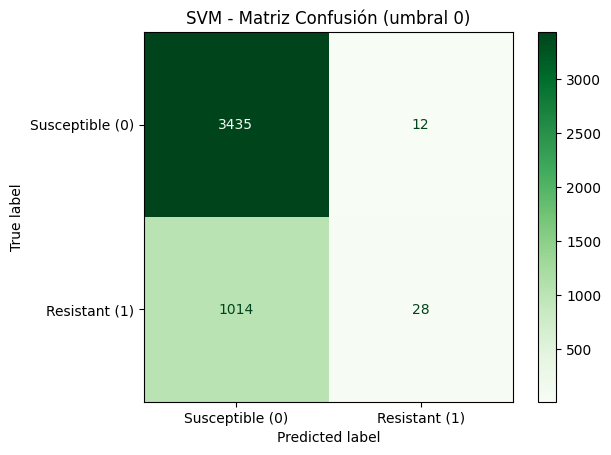

<Figure size 500x500 with 0 Axes>

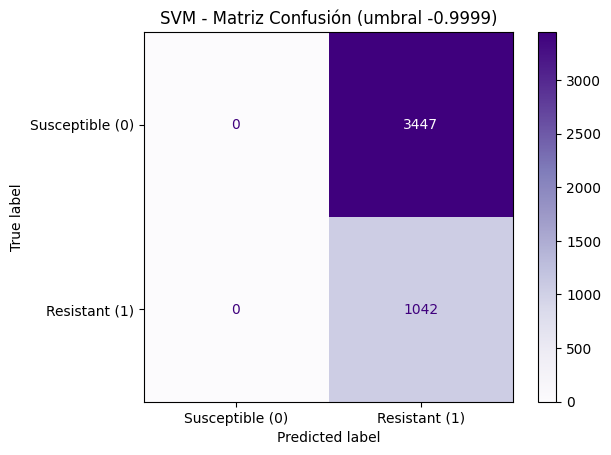

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix umbral 0 (decision_function ≥ 0)
cm_svm_default = confusion_matrix(y_test, y_pred_05)
disp_svm_default = ConfusionMatrixDisplay(cm_svm_default, display_labels=['Susceptible (0)', 'Resistant (1)'])
plt.figure(figsize=(5, 5))
disp_svm_default.plot(cmap='Greens', values_format='d')
plt.title('SVM - Matriz Confusión (umbral 0)')
plt.show()

# Confusion Matrix umbral óptimo
cm_svm_opt = confusion_matrix(y_test, y_pred_svm_opt)
disp_svm_opt = ConfusionMatrixDisplay(cm_svm_opt, display_labels=['Susceptible (0)', 'Resistant (1)'])
plt.figure(figsize=(5, 5))
disp_svm_opt.plot(cmap='Purples', values_format='d')
plt.title(f'SVM - Matriz Confusión (umbral {best_thr_s:.4f})')
plt.show()

In [45]:
# Modelo 3 – XGBoost (optimizar por recall)

from xgboost import XGBClassifier

print("\n--- Modelo 3: XGBoost (optimizado por Recall) ---")

# 1. Validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Grid de hiperparámetros para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# 3. GridSearchCV optimizado por recall
grid_xgb = GridSearchCV(
    XGBClassifier(objective='binary:logistic', random_state=42),
    param_grid_xgb,
    cv=skf,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(X_train_svm, y_train)  # X_train_svm = X_train_scaled_std

print("Best XGBoost Params (Recall):", grid_xgb.best_params_)
y_pred_xgb = grid_xgb.predict(X_test_svm)
print("Test Report XGBoost:")
print(classification_report(y_test, y_pred_xgb, zero_division=0))


--- Modelo 3: XGBoost (optimizado por Recall) ---
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGBoost Params (Recall): {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Test Report XGBoost:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3447
           1       0.67      0.00      0.01      1042

    accuracy                           0.77      4489
   macro avg       0.72      0.50      0.44      4489
weighted avg       0.74      0.77      0.67      4489



In [46]:
# AUC-ROC y umbral óptimo para XGBoost

# 1. Sacar probabilidades de la clase “1”
y_prob_xgb = grid_xgb.predict_proba(X_test_svm)[:, 1]

# 2. Calcular AUC-ROC
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print("\nAUC-ROC XGBoost:", f"{auc_xgb:.4f}")

# 3. Buscar umbral óptimo (F1) en test
prec_x, rec_x, thr_x = precision_recall_curve(y_test, y_prob_xgb)
best_f1_x, best_thr_x = 0, 0.5
for p, r, t in zip(prec_x[:-1], rec_x[:-1], thr_x):
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    if f1 > best_f1_x:
        best_f1_x, best_thr_x = f1, t

print(f"XGB umbral óptimo: {best_thr_x:.4f} → F1 = {best_f1_x:.4f}")

# 4. Classification report a umbral 0.5
y_pred_05_x = (y_prob_xgb >= 0.5).astype(int)
print("\nClassification Report (XGBoost a umbral 0.5):")
print(classification_report(y_test, y_pred_05_x, zero_division=0))

# 5. Classification report a umbral óptimo
y_pred_xgb_opt = (y_prob_xgb >= best_thr_x).astype(int)
print(f"\nClassification Report (XGBoost a umbral {best_thr_x:.4f}):")
print(classification_report(y_test, y_pred_xgb_opt, zero_division=0))


AUC-ROC XGBoost: 0.5021
XGB umbral óptimo: 0.2275 → F1 = 0.3768

Classification Report (XGBoost a umbral 0.5):
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3447
           1       0.67      0.00      0.01      1042

    accuracy                           0.77      4489
   macro avg       0.72      0.50      0.44      4489
weighted avg       0.74      0.77      0.67      4489


Classification Report (XGBoost a umbral 0.2275):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3447
           1       0.23      1.00      0.38      1042

    accuracy                           0.23      4489
   macro avg       0.12      0.50      0.19      4489
weighted avg       0.05      0.23      0.09      4489



<Figure size 500x500 with 0 Axes>

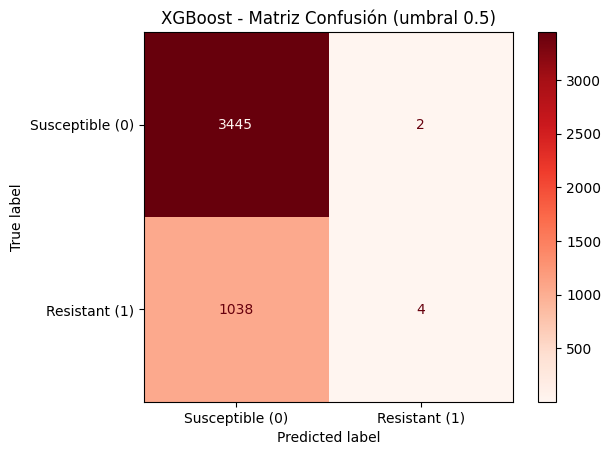

<Figure size 500x500 with 0 Axes>

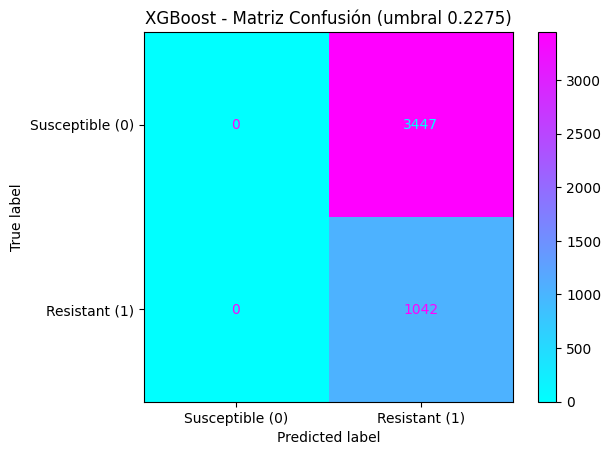

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix umbral 0.5
cm_xgb_default = confusion_matrix(y_test, y_pred_05_x)
disp_xgb_default = ConfusionMatrixDisplay(cm_xgb_default, display_labels=['Susceptible (0)', 'Resistant (1)'])
plt.figure(figsize=(5, 5))
disp_xgb_default.plot(cmap='Reds', values_format='d')
plt.title('XGBoost - Matriz Confusión (umbral 0.5)')
plt.show()

# Confusion Matrix umbral óptimo
cm_xgb_opt = confusion_matrix(y_test, y_pred_xgb_opt)
disp_xgb_opt = ConfusionMatrixDisplay(cm_xgb_opt, display_labels=['Susceptible (0)', 'Resistant (1)'])
plt.figure(figsize=(5, 5))
disp_xgb_opt.plot(cmap='cool', values_format='d')
plt.title(f'XGBoost - Matriz Confusión (umbral {best_thr_x:.4f})')
plt.show()

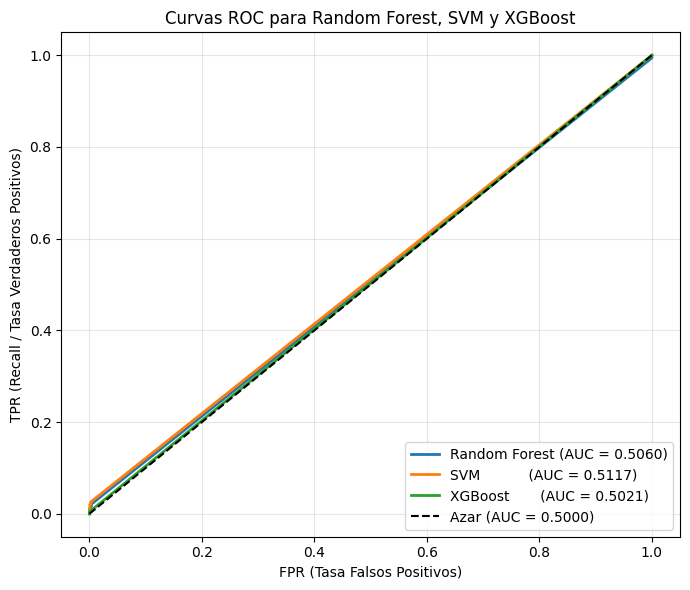

In [52]:
from sklearn.metrics import roc_curve, auc

# 1. Random Forest: usamos predict_proba directamente
y_prob_rf = grid_rf.predict_proba(X_test_rf)[:, 1]

# 2. SVM: usamos decision_function en lugar de predict_proba
decision_scores_svm = grid_svm.best_estimator_.decision_function(X_test_svm)
y_prob_svm = decision_scores_svm

# 3. XGBoost: usamos predict_proba
y_prob_xgb = grid_xgb.predict_proba(X_test_xgb)[:, 1]

# 1. Calcular las curvas ROC para cada modelo
fpr_rf, tpr_rf, _    = roc_curve(y_test, y_prob_rf)
fpr_svm, tpr_svm, _  = roc_curve(y_test, y_prob_svm)
fpr_xgb, tpr_xgb, _  = roc_curve(y_test, y_prob_xgb)

# 2. Calcular el AUC para cada curva
auc_rf  = auc(fpr_rf, tpr_rf)
auc_svm = auc(fpr_svm, tpr_svm)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# 3. Dibujar las tres curvas en un mismo gráfico
plt.figure(figsize=(7, 6))

plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.4f})",  linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f"SVM           (AUC = {auc_svm:.4f})", linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost       (AUC = {auc_xgb:.4f})",  linewidth=2)

# Línea de referencia: clasificador aleatorio
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC = 0.5000)")

plt.title("Curvas ROC para Random Forest, SVM y XGBoost")
plt.xlabel("FPR (Tasa Falsos Positivos)")
plt.ylabel("TPR (Recall / Tasa Verdaderos Positivos)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

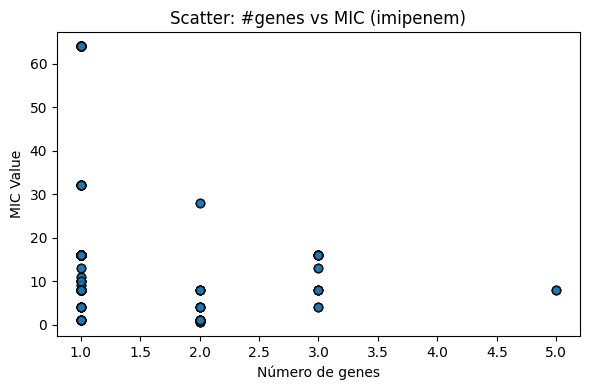

Pearson r = -0.193, p-value = 4.232e-08
Spearman rho = -0.302, p-value = 2.907e-18


In [53]:
# Análisis de correlación entre recuento de genes y valores de MIC

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

df_genoma_raw = pd.read_excel(path_genoma, dtype=str)

# 2. Normalizar 'Genome ID' y convertir MIC a numérico
df_genoma_raw['Genome ID'] = df_genoma_raw['Genome ID'].astype(str).str.strip().str.lower()
df_genoma_raw['MIC_Value'] = pd.to_numeric(df_genoma_raw['Measurement Value'], errors='coerce')

# 3. Calcular recuento de genes por genoma en df_full
gene_cols = df_full.columns.difference(['Genome ID', 'Resistance'])
df_full['Num_Genes'] = df_full[gene_cols].sum(axis=1)

# 4. Elegir un antibiótico (imipenem)
antib = 'imipenem'
df_mic = df_genoma_raw[df_genoma_raw['Antibiotic'].str.lower() == antib].copy()

# 5. Unir recuento de genes con MIC
df_merge = df_full.merge(
    df_mic[['Genome ID', 'MIC_Value']],
    on='Genome ID',
    how='inner'
).dropna(subset=['MIC_Value'])

# 6. Scatter plot: Num_Genes vs MIC_Value
plt.figure(figsize=(6, 4))
plt.scatter(df_merge['Num_Genes'], df_merge['MIC_Value'],
            alpha=0.6, color='tab:blue', edgecolor='k')
plt.title(f'Scatter: #genes vs MIC ({antib})')
plt.xlabel('Número de genes')
plt.ylabel('MIC Value')
plt.tight_layout()
plt.show()

# 7. Calcular correlaciones
pearson_corr, p_p = pearsonr(df_merge['Num_Genes'], df_merge['MIC_Value'])
spearman_corr, p_s = spearmanr(df_merge['Num_Genes'], df_merge['MIC_Value'])
print(f"Pearson r = {pearson_corr:.3f}, p-value = {p_p:.3e}")
print(f"Spearman rho = {spearman_corr:.3f}, p-value = {p_s:.3e}")

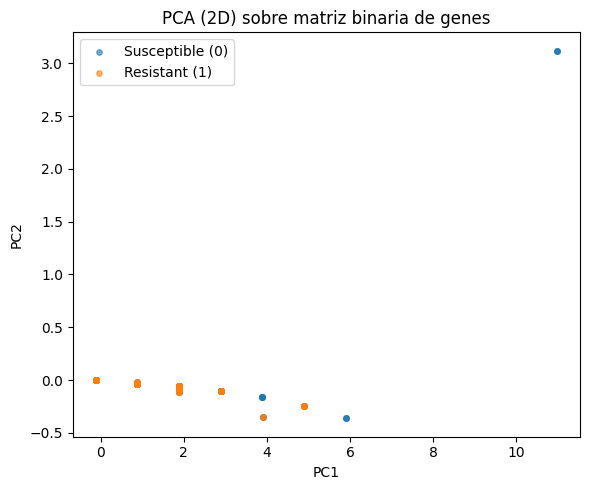

C:\Users\judit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


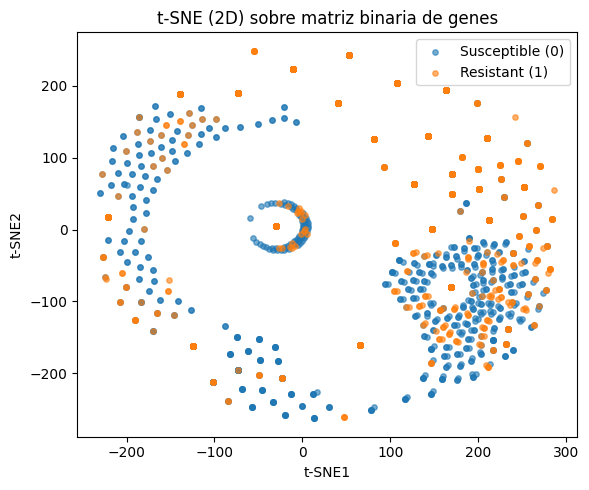

In [54]:
# Análisis de componentes principales (PCA) y t-SNE

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Definir gene_cols y extraer matriz binaria + etiqueta
gene_cols = [c for c in df_full.columns if c not in ['Genome ID', 'Resistance']]
X_bin = df_full[gene_cols]
y_bin = df_full['Resistance']

# PCA a 2 componentes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_bin)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_pca[y_bin == 0, 0], X_pca[y_bin == 0, 1],
    alpha=0.6, label='Susceptible (0)', s=15, color='tab:blue'
)
plt.scatter(
    X_pca[y_bin == 1, 0], X_pca[y_bin == 1, 1],
    alpha=0.6, label='Resistant (1)', s=15, color='tab:orange'
)
plt.title("PCA (2D) sobre matriz binaria de genes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# t-SNE a 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_bin)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_tsne[y_bin == 0, 0], X_tsne[y_bin == 0, 1],
    alpha=0.6, label='Susceptible (0)', s=15, color='tab:blue'
)
plt.scatter(
    X_tsne[y_bin == 1, 0], X_tsne[y_bin == 1, 1],
    alpha=0.6, label='Resistant (1)', s=15, color='tab:orange'
)
plt.title("t-SNE (2D) sobre matriz binaria de genes")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend()
plt.tight_layout()
plt.show()

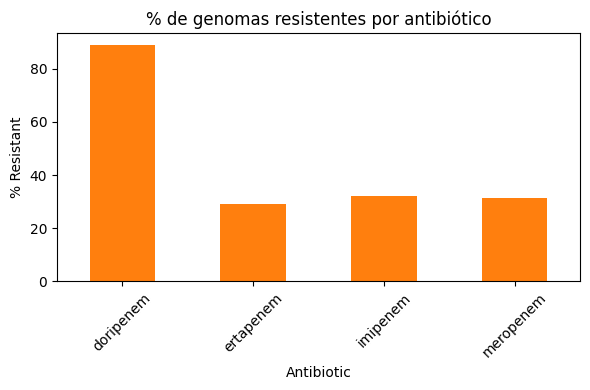

Resistentes a Imipenem: 10461
Resistentes a Meropenem: 10426
Resistentes a ambos: 9496


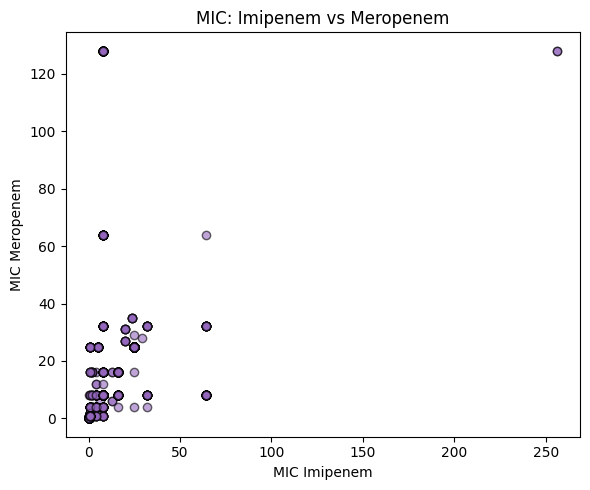

In [37]:
# Análisis de subtipos de antibióticos (evolución fenotípica)

import pandas as pd
import matplotlib.pyplot as plt

# 1. Leer y preparar df_genoma_raw con MIC_Value
df_genoma_raw = pd.read_excel(path_genoma, dtype=str)
df_genoma_raw['Genome ID'] = df_genoma_raw['Genome ID'].astype(str).str.strip().str.lower()
df_genoma_raw['MIC_Value'] = pd.to_numeric(df_genoma_raw['Measurement Value'], errors='coerce')

# 2. Crear columna binaria de resistencia
df_pheno = df_genoma_raw.copy()
df_pheno['Resistance_bin'] = df_pheno['Resistant Phenotype'].map({'Resistant': 1, 'Susceptible': 0})

# 3. Proporción de resistentes por antibiótico
counts_by_ant = (
    df_pheno
    .groupby(['Antibiotic', 'Resistance_bin'])['Genome ID']
    .nunique()
    .unstack(fill_value=0)
)
counts_by_ant['Total'] = counts_by_ant.sum(axis=1)
counts_by_ant['%Resistant'] = counts_by_ant[1] / counts_by_ant['Total'] * 100

plt.figure(figsize=(6, 4))
counts_by_ant['%Resistant'].plot(kind='bar', color='tab:orange')
plt.title("% de genomas resistentes por antibiótico")
plt.xlabel("Antibiotic")
plt.ylabel("% Resistant")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Contingencia de resistencia simultánea Imipenem vs Meropenem
imp = set(
    df_pheno[
        (df_pheno['Antibiotic'].str.lower() == 'imipenem') &
        (df_pheno['Resistance_bin'] == 1)
    ]['Genome ID']
)
mer = set(
    df_pheno[
        (df_pheno['Antibiotic'].str.lower() == 'meropenem') &
        (df_pheno['Resistance_bin'] == 1)
    ]['Genome ID']
)
print(f"Resistentes a Imipenem: {len(imp)}")
print(f"Resistentes a Meropenem: {len(mer)}")
print(f"Resistentes a ambos: {len(imp & mer)}")

# 5. Scatter MIC Imipenem vs Meropenem para genomas con ambos valores
df_imp_mic = df_pheno[df_pheno['Antibiotic'].str.lower() == 'imipenem'][['Genome ID', 'MIC_Value']]
df_mer_mic = df_pheno[df_pheno['Antibiotic'].str.lower() == 'meropenem'][['Genome ID', 'MIC_Value']]

df_scatter = (
    df_imp_mic.merge(df_mer_mic, on='Genome ID', suffixes=('_imp', '_mer'))
    .dropna(subset=['MIC_Value_imp', 'MIC_Value_mer'])
)

plt.figure(figsize=(6, 5))
plt.scatter(
    df_scatter['MIC_Value_imp'],
    df_scatter['MIC_Value_mer'],
    alpha=0.6, color='tab:purple', edgecolor='k'
)
plt.title("MIC: Imipenem vs Meropenem")
plt.xlabel("MIC Imipenem")
plt.ylabel("MIC Meropenem")
plt.tight_layout()
plt.show()